# 通し課題　Day1 →　Day2→　Day3→　Day4

　kaggleのデータセット「Kickstarter Projects」を用いてクラウドファンデイングが成功するか(state)を予測する。
 
 - day1:前処理　不要なデータを削除してから質的変数の変換　ロジスティック回帰
 - day2:相関係数確認　標準化　ホールドアウト法　交差検証　SVM（ハイパーパラメータ手動設定・グリッドサーチ）
 - day3:特徴選択　決定木、アダブースト、ニューラルネットワーク
 - day4:主成分分析

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.preprocessing import StandardScaler #標準化に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
#データ読み込み
df_ks=pd.read_csv("ks-projects-201801.csv")
#df_ks=df_ks.iloc[0:10000,:]


#### Day1前処理・ロジスティック回帰

データの統計情報確認・前処理

In [3]:
#データ情報
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


欠損値は「name」と「usd pledged」のみ

In [4]:
#データ情報
df_ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


各列の意味を確認
- ID：個別ID
- name:名前
- category：詳細カテゴリー
- main_category：カテゴリー
- currency：通貨
- deadline：締め切りの日付
- goal：目標額
- launched：開始日
- pledged：集まった額
- state：状態
- backers：支援者数
- country：国
- usd pledged：アメリカドル換算の集計額
- usd_pledged_real：アメリカドル換算の集計額(fixerAPI換算)
- usd_goal_real：アメリカドル換算の目標額(fixerAPI換算)

In [5]:
#予測に使用しない「ID]や[name]列を削除
df_ks_pre=df_ks.drop(columns=["ID","name"])
#開始後に値が決定する列を削除
df_ks_pre=df_ks_pre.drop(columns=["pledged","backers","usd pledged","usd_pledged_real"])
#意味が重複する列を削除
df_ks_pre=df_ks_pre.drop(columns=["goal"])

In [6]:
#不要な列削除後のデータ情報
df_ks_pre.head()

,category,main_category,currency,deadline,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,19500.00


In [7]:
#欠損値確認
df_ks_pre.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

欠損値なし

In [8]:
#結果が出ているデータのみ抽出
df_ks_pre=df_ks_pre.loc[(df_ks_pre['state']=='successful') | (df_ks_pre['state']=='failed')]

#結果を数値に変換
df_ks_pre.loc[df_ks_pre['state']=='successful','state_num']=1
df_ks_pre.loc[df_ks_pre['state']=='failed','state_num']=0

#変換した元の列を削除
df_ks_pre=df_ks_pre.drop(columns=['state'])

#インデックス振り直し
df_ks_pre.reset_index(inplace = True)
df_ks_pre=df_ks_pre.drop(columns=['index'])

df_ks_pre.head()
print(df_ks_pre.describe())

       usd_goal_real      state_num
count   3.316750e+05  331675.000000
mean    4.151000e+04       0.403877
std     1.108930e+06       0.490674
min     1.000000e-02       0.000000
25%     2.000000e+03       0.000000
50%     5.000000e+03       0.000000
75%     1.500000e+04       1.000000
max     1.663614e+08       1.000000


In [9]:
###### カテゴリ変数と思われる項目の値を確認
print(df_ks_pre["category"].value_counts())
print(df_ks_pre["main_category"].value_counts())
print(df_ks_pre["currency"].value_counts())
print(df_ks_pre["country"].value_counts())

Product Design       18680
Documentary          14523
Music                12633
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9328
Film & Video          8624
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6166
Technology            5726
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5052
Narrative Film        4618
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3115
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

In [10]:
#カテゴリ変数の値が少ないものを「その他」に変換する
d_category=df_ks_pre["category"].value_counts().to_dict()
#print(d_category)
other_category = [k for k, v in d_category.items() if v < 5000]
print(other_category)
df_ks_pre.loc[df_ks_pre['category'].isin(other_category),'category']='category_Others'

print(df_ks_pre.head())

['Narrative Film', 'Comics', 'Web', 'Country & Folk', 'Crafts', 'Design', 'Hip-Hop', 'Hardware', 'Pop', 'Painting', 'Illustration', 'Public Art', 'Accessories', 'Games', 'Software', 'Restaurants', 'Mixed Media', 'Comic Books', 'Art Books', 'Classical Music', 'Gadgets', 'Dance', 'Animation', 'Drinks', 'Comedy', 'Playing Cards', 'Performance Art', 'World Music', 'Drama', 'Electronic Music', 'Graphic Design', 'Jazz', 'Graphic Novels', 'Sculpture', 'Small Batch', 'Food Trucks', 'Journalism', 'Mobile Games', 'Photobooks', 'Plays', 'Poetry', 'Digital Art', 'Periodicals', 'Horror', 'Woodworking', 'Jewelry', 'Farms', 'DIY', 'Faith', 'Wearables', 'People', 'Performances', 'Conceptual Art', 'Live Games', 'Television', 'Radio & Podcasts', 'Musical', 'Experimental', 'DIY Electronics', 'Footwear', 'Academic', 'Festivals', 'Spaces', 'Ready-to-wear', 'Anthologies', 'Young Adult', 'Events', 'Fine Art', 'Science Fiction', 'Metal', 'Architecture', 'Places', 'Thrillers', 'Music Videos', 'Action', 'Print'

In [11]:
#質的変数を変換
enc=OneHotEncoder(sparse=False)

#質的変数のリスト
#'category','main_category','currency','country'
category_list={"category","main_category","currency","country"}

for i in category_list:
    X=df_ks_pre[[i]].values.reshape(-1,1)
    #X=df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1)
    print(X.shape)
    X_trans = enc.fit_transform(X)
    #enc.fit(df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1))
    print(enc.categories_)

    #X_trans = enc.transform(df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1))
    print(X_trans.shape)
    df_ks_trans =pd.DataFrame(X_trans,columns=enc.categories_[0])
    df_ks_pre=pd.concat([df_ks_pre,df_ks_trans],axis=1)

df_ks_trans=df_ks_pre    
print(df_ks_trans.head())


(331675, 1)
[array(['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion',
       'Film & Video', 'Food', 'Games', 'Journalism', 'Music',
       'Photography', 'Publishing', 'Technology', 'Theater'], dtype=object)]
(331675, 15)
(331675, 1)
[array(['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK',
       'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"', 'NL', 'NO', 'NZ', 'SE', 'SG',
       'US'], dtype=object)]
(331675, 23)
(331675, 1)
[array(['Apparel', 'Apps', 'Art', "Children's Books", 'Documentary',
       'Fashion', 'Fiction', 'Film & Video', 'Food', 'Indie Rock',
       'Music', 'Nonfiction', 'Photography', 'Product Design',
       'Publishing', 'Rock', 'Shorts', 'Tabletop Games', 'Technology',
       'Theater', 'Video Games', 'Webseries', 'category_Others'],
      dtype=object)]
(331675, 23)
(331675, 1)
[array(['AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP', 'HKD', 'JPY', 'MXN',
       'NOK', 'NZD', 'SEK', 'SGD', 'USD'], dtype=object)]
(331675, 14)
          category main_categor

In [12]:
#変換した質的変数の列を削除
df_ks_trans=df_ks_trans.drop(columns=['category','main_category','currency','country'])

df_ks_trans.head()

,deadline,launched,usd_goal_real,state_num,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,2015-10-09,2015-08-11 12:12:28,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-11-01,2017-09-02 04:43:57,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2013-02-26,2013-01-12 00:20:50,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2012-04-16,2012-03-17 03:24:11,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2016-04-01,2016-02-26 13:38:27,50000.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
#日付を期間に変換
df_ks_trans['period']=pd.to_datetime(df_ks_trans.loc[:,'deadline'],format='%Y-%m-%d')-pd.to_datetime(df_ks_trans.loc[:,'launched'],format='%Y-%m-%d %H:%M:%S')
df_ks_trans['period']=df_ks_trans['period'].dt.days

#変換した元の列を削除
df_ks_trans=df_ks_trans.drop(columns=['deadline','launched'])

print(df_ks_trans.head())

   usd_goal_real  state_num  Art  Comics  Crafts  Dance  Design  Fashion  \
0        1533.95        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
1       30000.00        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
2       45000.00        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
3        5000.00        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
4       50000.00        1.0  0.0     0.0     0.0    0.0     0.0      0.0   

   Film & Video  Food  ...  GBP  HKD  JPY  MXN  NOK  NZD  SEK  SGD  USD  \
0           0.0   0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           1.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2           1.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3           0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4           0.0   1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

   period  
0      58  
1      59  
2      44  
3      29  
4      34  

[5 rows x 78 column

C:\Users\mura\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#基本統計量
print(df_ks_trans.loc[:,["usd_goal_real","period"]].describe())

       usd_goal_real         period
count   3.316750e+05  331675.000000
mean    4.151000e+04      32.954902
std     1.108930e+06      12.713329
min     1.000000e-02       0.000000
25%     2.000000e+03      29.000000
50%     5.000000e+03      29.000000
75%     1.500000e+04      35.000000
max     1.663614e+08      91.000000


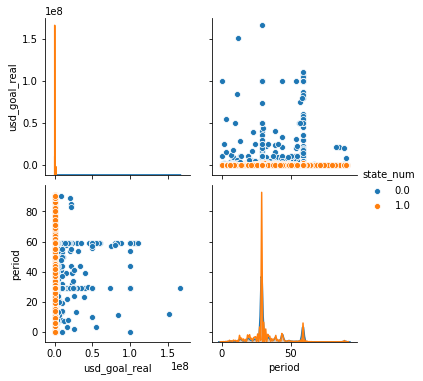

In [15]:
# 散布図行列
sns.pairplot(df_ks_trans.loc[:,["usd_goal_real","state_num","period"]],hue="state_num")

In [16]:
# 相関係数を確認
df_ks_trans.loc[:,["usd_goal_real","state_num","period"]].corr()

,usd_goal_real,state_num,period
usd_goal_real,1.000000,-0.023735,0.021607
state_num,-0.023735,1.000000,-0.116437
period,0.021607,-0.116437,1.000000


カテゴリ変数は相関がないので除外して確認

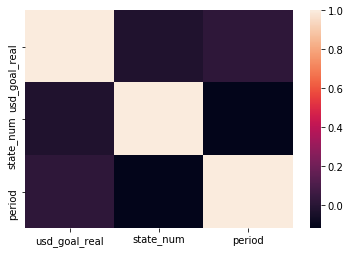

In [17]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_trans.loc[:,["usd_goal_real","state_num","period"]].corr())
plt.show()

相関の強い変数は無さそう

#### ロジスティック回帰

In [18]:
#目的変数と説明変数を抽出
y=df_ks_trans.loc[:,['state_num']].values
X=df_ks_trans.drop(columns='state_num').values

clf=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                 fit_intercept=True,random_state=1234,tol=1e-3)
#学習
clf.fit(X,y)

#予測
y_est=clf.predict(X)

#確率値
y_est_proba = clf.predict_proba(X)

#対数尤度
print('対数尤度={:.3f}'.format(-log_loss(y,y_est_proba,normalize=False)))

d1_SGD_accuracy=accuracy_score(y,y_est)
#正答率
print('正答率={:.3f}%'.format(100*d1_SGD_accuracy))

#予測値と正解のクロス集計
conf_mat=pd.DataFrame(confusion_matrix(y,y_est),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
conf_mat

C:\Users\mura\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


対数尤度=-5112015.217
正答率=55.376%


,予測=failed,予測=successful
正解=failed,83252,114467
正解=successful,33541,100415


#### Day2 ホールドアウト法・交差検証、標準化とSVM

- SVMで学習・予測(ハイパーパラメータを手動設定)

In [19]:
def SVM_manual(X_train_stand_SVC,y_train_SVC,X_test_stand_SVC,y_test_SVC):

    """
    X_train_stand_SVC:標準化済み学習データ目的変数
    y_train_SVC：学習データ説明変数
    X_test_stand_SVC：標準化済み予測データ目的変数
    y_test_SVC : 予測データ説明変数
    """
    print('SVMで学習・予測(ハイパーパラメータを手動設定**********************************')

    #ハイパーパラメータ
    C = 5
    kernel = "rbf"
    gamma = "scale"
    #学習
    clf_SVC=SVC(C=C, kernel=kernel, gamma=gamma)
    clf_SVC.fit(X_train_stand_SVC,y_train_SVC)

    #予測
    y_est_SVC=clf_SVC.predict(X_test_stand_SVC)

    #正答率
    accuracy_SVC=accuracy_score(y_test_SVC,y_est_SVC)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_SVC))

    #Precision,Recall,F1-score
    precision_SVC,recall_SVC,f1_score_SVC,_=precision_recall_fscore_support(y_test_SVC,y_est_SVC)
    print('適合率(Precision)={:.3f}%'.format(100*precision_SVC[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_SVC[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_SVC[1]))

    #予測値と正解のクロス集計
    conf_mat_SVC=pd.DataFrame(confusion_matrix(y_test_SVC,y_est_SVC),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_SVC)
    
    return accuracy_SVC

- SVMで学習・予測(グリッドサーチ)

In [20]:
def SVC_GridS(X_train_stand_GriS,y_train_GriS,X_test_stand_GriS,y_test_GriS):

    """
    X_train_stand_GriS:標準化済み学習データ目的変数
    y_train_GriS：学習データ説明変数
    X_test_stand_GriS：標準化済み予測データ目的変数
    y_test_GriS : 予測データ説明変数
    """
    print('SVMで学習・予測(グリッドサーチ)**********************************')

    #パラメータ候補設定とパラメータの学習
    parameters = {'kernel':['rbf','linear'], 'C':[1, 5, 10]}
    model = SVC(gamma="scale") #gamma自動計算
    clf_GriS = GridSearchCV(model, parameters, cv=3,)
    clf_GriS.fit(X_train_stand_GriS, y_train_GriS)
    print(clf_GriS.best_params_, clf_GriS.best_score_)

    # 最適パラメータを用いて識別する
    clf2_GriS = SVC(**clf_GriS.best_params_, gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
    clf2_GriS.fit(X_train_stand_GriS, y_train_GriS)
    print("識別精度=",clf2_GriS.score(X_test_stand_GriS, y_test_GriS))

    #予測
    y_est_GriS=clf2_GriS.predict(X_test_stand_GriS)

    #正答率
    accuracy_GriS=accuracy_score(y_test_GriS,y_est_GriS)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_GriS))

    #Precision,Recall,F1-score
    precision_GriS,recall_GriS,f1_score_GriS,_=precision_recall_fscore_support(y_test_GriS,y_est_GriS)
    print('適合率(Precision)={:.3f}%'.format(100*precision_GriS[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_GriS[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_GriS[1]))

    #予測値と正解のクロス集計
    conf_mat_GriS=pd.DataFrame(confusion_matrix(y_test_GriS,y_est_GriS),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_GriS)
    
    return accuracy_GriS


- ロジスティック回帰

In [21]:
def SGD(X_train_stand_SGD,y_train_SGD,X_test_stand_SGD,y_test_SGD):

    """
    X_train_stand_SGD:標準化済み学習データ目的変数
    y_train_SGD：学習データ説明変数
    X_test_stand_SGD：標準化済み予測データ目的変数
    y_test_SGD : 予測データ説明変数
    """
    print('ロジスティック回帰学習**********************************')

    #学習
    clf_SGD=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                     fit_intercept=True,random_state=1234,tol=1e-3)
    clf_SGD.fit(X_train_stand_SGD,y_train_SGD)

    #予測
    y_est_SGD=clf_SGD.predict(X_test_stand_SGD)

    #正答率
    accuracy_SGD=accuracy_score(y_test_SGD,y_est_SGD)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_SGD))

    #Precision,Recall,F1-score
    precision_SGD,recall_SGD,f1_score_SGD,_=precision_recall_fscore_support(y_test_SGD,y_est_SGD)
    print('適合率(Precision)={:.3f}%'.format(100*precision_SGD[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_SGD[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_SGD[1]))

    #予測値と正解のクロス集計
    conf_mat_SGD=pd.DataFrame(confusion_matrix(y_test_SGD,y_est_SGD),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_SGD)
    
    return accuracy_SGD


#### ホールドアウト法

SVM(ハイパーパラメータ手動設定)

In [22]:
#ホールドアウト法

#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_svm=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_svm.drop('state_num',axis=1)
X, y = df_X.values, df_ks_svm["state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#標準化したデータを確認
df_train_std = pd.DataFrame(X_train_stand, columns=df_X.columns)
print(df_train_std.describe())
df_test_std = pd.DataFrame(X_test_stand, columns=df_X.columns)
print(df_test_std.describe())

#SVM（パラメータ手動設定）
d2_h_final_SVM_manual_accuracy=SVM_manual(X_train_stand,y_train,X_test_stand,y_test)


(1000, 77)
(1000,)
       usd_goal_real           Art        Comics        Crafts         Dance  \
count   8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02   
mean   -3.198830e-17 -3.769207e-16 -1.221939e-16 -5.353357e-17 -5.421011e-16   
std     1.000626e+00  1.000626e+00  1.000626e+00  1.000626e+00  1.000626e+00   
min    -2.612337e-01 -3.096618e-01 -1.758631e-01 -1.180750e-01 -1.234035e-01   
25%    -2.392041e-01 -3.096618e-01 -1.758631e-01 -1.180750e-01 -1.234035e-01   
50%    -2.061432e-01 -3.096618e-01 -1.758631e-01 -1.180750e-01 -1.234035e-01   
75%    -9.594026e-02 -3.096618e-01 -1.758631e-01 -1.180750e-01 -1.234035e-01   
max     1.737970e+01  3.229330e+00  5.686241e+00  8.469196e+00  8.103497e+00   

             Design       Fashion  Film & Video          Food         Games  \
count  8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02   
mean   2.287059e-16  6.473988e-17  1.515454e-16  1.859624e-17  3.058664e-16   
std    1.000626e+00  1.

SVM(グリッドサーチ)

In [23]:
#ホールドアウト法

#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_svm=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_svm.drop('state_num',axis=1)
X, y = df_X.values, df_ks_svm["state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#SVM(グリッドサーチ)
d2_h_final_SVC_GridS_accuracy=SVC_GridS(X_train_stand,y_train,X_test_stand,y_test)


(1000, 77)
(1000,)
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'linear'} 0.56875
識別精度= 0.595
正答率(Accuracy) = 59.500%
適合率(Precision)=44.898%
再現率(Recall)=28.947%
F1値(F1-score)=35.200%
               予測=failed  予測=successful
正解=failed             97             27
正解=successful         54             22


ロジスティック回帰

In [24]:
#ホールドアウト法

#全件学習・予測
df_ks_sgd=df_ks_trans.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_sgd.drop('state_num',axis=1)
X, y = df_X.values, df_ks_sgd["state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#ロジスティック回帰
d2_h_final_SGD_accuracy=SGD(X_train_stand,y_train,X_test_stand,y_test)


(331675, 77)
(331675,)
ロジスティック回帰学習**********************************
正答率(Accuracy) = 65.049%
適合率(Precision)=57.346%
再現率(Recall)=50.201%
F1値(F1-score)=53.536%
               予測=failed  予測=successful
正解=failed          29793           9935
正解=successful      13250          13357


In [25]:
print("Holdout SVM manual 正答率(Accuracy) = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Holdout SVM gridsearch 正答率(Accuracy) = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Holdout SGD 正答率(Accuracy) = {:.3f}%".format(100*d2_h_final_SGD_accuracy))


Holdout SVM manual 正答率(Accuracy) = 61.000%
Holdout SVM gridsearch 正答率(Accuracy) = 59.500%
Holdout SGD 正答率(Accuracy) = 65.049%


#### 交差検証

SVM(ハイパーパラメータ手動設定)

In [26]:
#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_svm=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_svm.drop('state_num',axis=1)
X, y = df_X.values, df_ks_svm["state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVM_manual_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM（パラメータ手動設定）
    accuracy_SVM_manual=SVM_manual(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVM_manual_accuracy += accuracy_SVM_manual

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d2_CV_final_SVM_manual_accuracy = cross_SVM_manual_accuracy / n_split


(1000, 77)
(1000,)
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 61.000%
適合率(Precision)=48.276%
再現率(Recall)=36.842%
F1値(F1-score)=41.791%
               予測=failed  予測=successful
正解=failed             94             30
正解=successful         48             28
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 59.000%
適合率(Precision)=52.113%
再現率(Recall)=43.529%
F1値(F1-score)=47.436%
               予測=failed  予測=successful
正解=failed             81             34
正解=successful         48             37
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 57.000%
適合率(Precision)=54.348%
再現率(Recall)=27.778%
F1値(F1-score)=36.765%
               予測=failed  予測=successful
正解=failed             89             21
正解=successful         65             25
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 59.000%
適合率(Precision)=55.932%
再現率(Recall)=37.079%
F1値(F1-score)=44.595%
               予測=failed  予測=

SVMで学習・予測(グリッドサーチ)

In [27]:
#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_svm=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_svm.drop('state_num',axis=1)
X, y = df_X.values, df_ks_svm["state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVC_GridS_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM(グリッドサーチ)
    accuracy_SVC_GridS=SVC_GridS(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVC_GridS_accuracy += accuracy_SVC_GridS

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d2_CV_final_SVC_GridS_accuracy = cross_SVC_GridS_accuracy / n_split


(1000, 77)
(1000,)
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 5, 'kernel': 'linear'} 0.56
識別精度= 0.595
正答率(Accuracy) = 59.500%
適合率(Precision)=44.898%
再現率(Recall)=28.947%
F1値(F1-score)=35.200%
               予測=failed  予測=successful
正解=failed             97             27
正解=successful         54             22
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.5925
識別精度= 0.605
正答率(Accuracy) = 60.500%
適合率(Precision)=54.688%
再現率(Recall)=41.176%
F1値(F1-score)=46.980%
               予測=failed  予測=successful
正解=failed             86             29
正解=successful         50             35
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.5725
識別精度= 0.58
正答率(Accuracy) = 58.000%
適合率(Precision)=57.895%
再現率(Recall)=24.444%
F1値(F1-score)=34.375%
               予測=failed  予測=successful
正解=failed             94             16
正解=successful         68             22
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1

ロジスティック回帰で学習・予測(グリッドサーチ)

In [28]:
#全件学習・予測
df_ks_sgd=df_ks_trans.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_sgd.drop('state_num',axis=1)
X, y = df_X.values, df_ks_sgd["state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #ロジスティック回帰
    accuracy_SGD=SGD(X_train_stand,y_train,X_test_stand,y_test)

    cross_SGD_accuracy += accuracy_SGD

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d2_CV_final_SGD_accuracy = cross_SGD_accuracy / n_split


(331675, 77)
(331675,)
ロジスティック回帰学習**********************************
正答率(Accuracy) = 65.911%
適合率(Precision)=61.008%
再現率(Recall)=41.598%
F1値(F1-score)=49.467%
               予測=failed  予測=successful
正解=failed          32654           7074
正解=successful      15539          11068
ロジスティック回帰学習**********************************
正答率(Accuracy) = 65.122%
適合率(Precision)=58.731%
再現率(Recall)=46.804%
F1値(F1-score)=52.093%
               予測=failed  予測=successful
正解=failed          30620           8839
正解=successful      14297          12579
ロジスティック回帰学習**********************************
正答率(Accuracy) = 65.303%
適合率(Precision)=58.820%
再現率(Recall)=47.995%
F1値(F1-score)=52.859%
               予測=failed  予測=successful
正解=failed          30415           9034
正解=successful      13982          12904
ロジスティック回帰学習**********************************
正答率(Accuracy) = 65.160%
適合率(Precision)=58.239%
再現率(Recall)=48.582%
F1値(F1-score)=52.974%
               予測=failed  予測=successful
正解=failed          30207           93

In [29]:
print("Cross Validation SVM manual 正答率(Accuracy) = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Cross Validation SVM gridsearch 正答率(Accuracy) = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Cross Validation SGD 正答率(Accuracy) = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))


Cross Validation SVM manual 正答率(Accuracy) = 58.300%
Cross Validation SVM gridsearch 正答率(Accuracy) = 58.300%
Cross Validation SGD 正答率(Accuracy) = 65.424%


In [30]:
print('Day1 ロジスティック回帰　正答率={:.3f}%'.format(100*d1_SGD_accuracy))
print("Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Day2 ホールドアウト法　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_h_final_SGD_accuracy))
print("Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Day2 交差検証　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Day2 交差検証　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))


Day1 ロジスティック回帰　正答率=55.376%
Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = 61.000%
Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = 59.500%
Day2 ホールドアウト法　ロジスティック回帰　正答率 = 65.049%
Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = 58.300%
Day2 交差検証　SVM グリッドサーチ　正答率 = 58.300%
Day2 交差検証　ロジスティック回帰　正答率 = 65.424%


SVMは全データで学習に時間がかかるため、先頭から1000件を抽出して実施

#### Day3 特徴選択、ランダムフォレスト、NN

ラッパー法による特徴選択（ステップワイズ法）

In [31]:
from sklearn.feature_selection import RFECV

#モデルを選択(ロジスティック回帰)
estimator=SGDClassifier(loss='log',penalty='none',max_iter=10000,
                     fit_intercept=True,random_state=1234,tol=1e-3,n_jobs=-1)

rfecv=RFECV(estimator,cv=5,scoring='accuracy')

#全件学習・選択できなかったのでデータを絞る
df_ks_rfecv=df_ks_trans.iloc[:,:]
#df_ks_rfecv=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_rfecv.drop('state_num',axis=1)
X, y = df_X.values, df_ks_rfecv["state_num"].values
print(X.shape)
print(y.shape)

rfecv.fit(X,y)

print('Feature ranking: \n{}'.format(rfecv.ranking_))


(331675, 77)
(331675,)
Feature ranking: 
[ 1  1  2  8  7  1 17  1 19  1 18  1 59 14 11  1 47 21 58 34 33 41 50 44
 20  1 43 56 39 60 57 28 48 31 51 46 29 54  1 15 12  9 23  1 36 13 10 16
  5  3 24 38  1 26  6  1  1 25  4 55 37  1 22 35 32 49 40  1 42 61 27 52
 45 30 53  1  1]


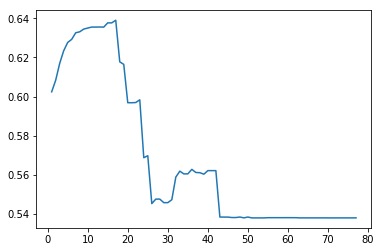

array([ True,  True, False, False, False,  True, False,  True, False,
        True, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True])

In [32]:
#特徴のスコアを表示
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.show()

rfecv.support_

In [33]:
#削除する列を指定
remove_idx=~rfecv.support_
remove_feature=df_X.columns[remove_idx]
print(remove_feature)

#列を削除
df_ks_rfecv=df_ks_rfecv.drop(remove_feature,axis=1)
print(df_ks_rfecv.info())

Index(['Comics', 'Crafts', 'Dance', 'Fashion', 'Food', 'Journalism',
       'Photography', 'Publishing', 'Technology', 'AT', 'AU', 'BE', 'CA', 'CH',
       'DE', 'DK', 'ES', 'FR', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"',
       'NL', 'NO', 'NZ', 'SE', 'SG', 'Apparel', 'Apps', 'Art',
       'Children's Books', 'Fashion', 'Fiction', 'Film & Video', 'Food',
       'Indie Rock', 'Music', 'Nonfiction', 'Photography', 'Publishing',
       'Rock', 'Technology', 'Theater', 'Video Games', 'Webseries', 'AUD',
       'CAD', 'CHF', 'DKK', 'EUR', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK',
       'SGD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 14 columns):
usd_goal_real      331675 non-null float64
state_num          331675 non-null float64
Design             331675 non-null float64
Games              331675 non-null float64
GB                 331675 non-null float64
US                 331675 non-null float64
Documenta

Lassoによる特徴選択

In [34]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

#全件学習・選択
df_ks_lasso=df_ks_trans.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_lasso.drop('state_num',axis=1)
X, y = df_X.values, df_ks_lasso["state_num"].values
print(X.shape)
print(y.shape)

estimator = LassoCV(normalize=True,cv=5,max_iter=10000)
sfm=SelectFromModel(estimator,threshold=1e-5)

#特徴選択を実行
sfm.fit(X,y)


(331675, 77)
(331675,)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [35]:
#特徴選択結果
print("特徴の使用・不使用(trueが使用する特徴)")
print(sfm.get_support())

#削除する特徴の変数名を取得
removed_idx=~sfm.get_support()
df_drop_X=df_X.columns[removed_idx]
print("削除する変数の名前")
print(df_drop_X)

#各特徴の係数の絶対値を取得
abs_coef=np.abs(sfm.estimator_.coef_)
print(abs_coef)

#列を削除
df_ks_lasso=df_ks_lasso.drop(df_drop_X,axis=1)
print(df_ks_lasso.head())

特徴の使用・不使用(trueが使用する特徴)
[False  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True False  True  True  True  True False  True
  True False  True  True  True  True  True  True  True  True  True  True
 False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True False  True  True  True False False  True  True False
  True  True  True  True  True]
削除する変数の名前
Index(['usd_goal_real', 'Film & Video', 'AU', 'DK', 'GB', 'SE', 'US',
       'category_Others', 'CAD', 'GBP', 'HKD', 'NOK'],
      dtype='object')
[7.74869606e-09 6.54357974e-02 2.14558576e-01 1.13291172e-01
 2.70815827e-01 1.36906697e-02 4.64984832e-02 0.00000000e+00
 1.32265889e-01 6.58631856e-02 1.24190949e-01 1.17597325e-01
 5.04591498e-02 6.57712444e-02 6.46862191e-02 2.15669738e-01
 3.96545183e-02 0.00000000e+00 2.76253427e-02 4.12813194e-02
 4.01711615e-02 4.03818529e-03 0.00000000e+00

ステップワイズ法／Lassoのどちらの特徴選択結果を学習に使用するか指定する

In [36]:
#特徴選択後のデータを設定（ステップワイズ法）
df_ks_select=df_ks_rfecv
#特徴選択後のデータを設定（Lasso）
#df_ks_select=df_ks_lasso

print(df_ks_select.head())

   usd_goal_real  state_num  Design  Games   GB   US  Documentary  \
0        1533.95        0.0     0.0    0.0  1.0  0.0          0.0   
1       30000.00        0.0     0.0    0.0  0.0  1.0          0.0   
2       45000.00        0.0     0.0    0.0  0.0  1.0          0.0   
3        5000.00        0.0     0.0    0.0  0.0  1.0          0.0   
4       50000.00        1.0     0.0    0.0  0.0  1.0          0.0   

   Product Design  Shorts  Tabletop Games  category_Others  GBP  USD  period  
0             0.0     0.0             0.0              1.0  1.0  0.0      58  
1             0.0     0.0             0.0              1.0  0.0  1.0      59  
2             0.0     0.0             0.0              1.0  0.0  1.0      44  
3             0.0     0.0             0.0              0.0  0.0  1.0      29  
4             0.0     0.0             0.0              1.0  0.0  1.0      34  


アダブースト（決定木）

In [37]:
def AdaB(X_train_stand_AdaB,y_train_AdaB,X_test_stand_AdaB,y_test_AdaB):

    """
    X_train_stand_AdaB:標準化済み学習データ目的変数
    y_train_AdaB：学習データ説明変数
    X_test_stand_AdaB：標準化済み予測データ目的変数
    y_test_AdaB : 予測データ説明変数
    """
    print('アダブースト（決定木）**********************************')

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier

    #決定木を指定してアダブースト
    clf_AdaB=AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,
                                                      min_samples_leaf=10,
                                                      min_samples_split=10,
                                                      random_state=1234,
                                                      criterion="gini"),
                                                      n_estimators=500,random_state=1234)
    clf_AdaB.fit(X_train_stand_AdaB,y_train_AdaB)
    print("score=",clf_AdaB.score(X_train_stand_AdaB,y_train_AdaB))    
    
    #予測
    y_est_AdaB=clf_AdaB.predict(X_test_stand_AdaB)

    #正答率
    accuracy_AdaB=accuracy_score(y_test_AdaB,y_est_AdaB)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_AdaB))

    #Precision,Recall,F1-score
    precision_AdaB,recall_AdaB,f1_score_AdaB,_=precision_recall_fscore_support(y_test_AdaB,y_est_AdaB)
    print('適合率(Precision)={:.3f}%'.format(100*precision_AdaB[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_AdaB[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_AdaB[1]))

    #予測値と正解のクロス集計
    conf_mat_AdaB=pd.DataFrame(confusion_matrix(y_test_AdaB,y_est_AdaB),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_AdaB)
    
    return accuracy_AdaB


決定木

(331675, 13)
(331675,)
score= 0.6531582121052235
Index(['usd_goal_real', 'Design', 'Games', 'GB', 'US', 'Documentary',
       'Product Design', 'Shorts', 'Tabletop Games', 'category_Others', 'GBP',
       'USD', 'period'],
      dtype='object')
[0.51438954 0.00181055 0.01036665 0.00077305 0.00398128 0.00963771
 0.01251295 0.02903097 0.08723999 0.00382051 0.00710892 0.01959822
 0.29972967]
['usd_goal_real', 'Design', 'Games', 'GB', 'US', 'Documentary', 'Product Design', 'Shorts', 'Tabletop Games', 'category_Others', 'GBP', 'USD', 'period']
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.346653 to fit



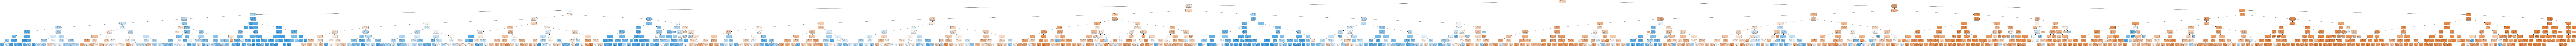

In [38]:
#決定木
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO


#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1)
X, y = df_X.values, df_ks_select.loc[:,"state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

clf = DecisionTreeClassifier(criterion="gini", 
                             max_depth=10, 
                             min_samples_leaf=10, 
                             random_state=1234)
clf = clf.fit(X_train_stand, y_train)
print("score=", clf.score(X_train_stand, y_train))
print(df_X.columns)
print(clf.feature_importances_)

#[Country & Folk]で問題が発生しているようなので、名称を変更する。
df_re_X=df_X.rename(columns={'Film & Video': 'Film Video'})

f_name=df_re_X.columns.values.tolist()
print(f_name)

# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names= f_name,  
                     class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

特徴選択後　交差検証　SVM（ハイパーパラメータ手動設定）

In [39]:

#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1).loc[:1000,:]
X, y = df_X.values, df_ks_trans.loc[:1000,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVM_manual_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM（パラメータ手動設定）
    accuracy_SVM_manual=SVM_manual(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVM_manual_accuracy += accuracy_SVM_manual

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_SVM_manual_accuracy = cross_SVM_manual_accuracy / n_split


(1001, 13)
(1001,)
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 59.701%
適合率(Precision)=44.444%
再現率(Recall)=15.385%
F1値(F1-score)=22.857%
               予測=failed  予測=successful
正解=failed            108             15
正解=successful         66             12
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 54.500%
適合率(Precision)=47.917%
再現率(Recall)=25.843%
F1値(F1-score)=33.577%
               予測=failed  予測=successful
正解=failed             86             25
正解=successful         66             23
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 58.000%
適合率(Precision)=56.522%
再現率(Recall)=14.943%
F1値(F1-score)=23.636%
               予測=failed  予測=successful
正解=failed            103             10
正解=successful         74             13
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 58.500%
適合率(Precision)=66.667%
再現率(Recall)=15.556%
F1値(F1-score)=25.225%
               予測=failed  予測=

特徴選択後　交差検証　SVM(グリッドサーチ)

In [40]:
#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1).loc[:1000,:]
X, y = df_X.values, df_ks_trans.loc[:1000,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVC_GridS_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM(グリッドサーチ)
    accuracy_SVC_GridS=SVC_GridS(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVC_GridS_accuracy += accuracy_SVC_GridS

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_SVC_GridS_accuracy = cross_SVC_GridS_accuracy / n_split


(1001, 13)
(1001,)
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'linear'} 0.5475
識別精度= 0.6169154228855721
正答率(Accuracy) = 61.692%
適合率(Precision)=52.632%
再現率(Recall)=12.821%
F1値(F1-score)=20.619%
               予測=failed  予測=successful
正解=failed            114              9
正解=successful         68             10
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'linear'} 0.5805243445692884
識別精度= 0.555
正答率(Accuracy) = 55.500%
適合率(Precision)=50.000%
再現率(Recall)=11.236%
F1値(F1-score)=18.349%
               予測=failed  予測=successful
正解=failed            101             10
正解=successful         79             10
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'linear'} 0.5730337078651685
識別精度= 0.585
正答率(Accuracy) = 58.500%
適合率(Precision)=66.667%
再現率(Recall)=9.195%
F1値(F1-score)=16.162%
               予測=failed  予測=successful
正解=failed            109              4
正解=successful         79              8
SVMで学習・予測(グリッドサ

特徴選択後　交差検証　ロジスティック回帰

In [41]:
#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1).loc[:,:]
X, y = df_X.values, df_ks_select.loc[:,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #ロジスティック回帰
    accuracy_SGD=SGD(X_train_stand,y_train,X_test_stand,y_test)

    cross_SGD_accuracy += accuracy_SGD

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_SGD_accuracy = cross_SGD_accuracy / n_split


(331675, 13)
(331675,)
ロジスティック回帰学習**********************************
正答率(Accuracy) = 62.462%
適合率(Precision)=58.692%
再現率(Recall)=21.648%
F1値(F1-score)=31.630%
               予測=failed  予測=successful
正解=failed          35674           4054
正解=successful      20847           5760
ロジスティック回帰学習**********************************
正答率(Accuracy) = 62.110%
適合率(Precision)=59.358%
再現率(Recall)=20.557%
F1値(F1-score)=30.538%
               予測=failed  予測=successful
正解=failed          35676           3783
正解=successful      21351           5525
ロジスティック回帰学習**********************************
正答率(Accuracy) = 62.094%
適合率(Precision)=60.149%
再現率(Recall)=19.188%
F1値(F1-score)=29.095%
               予測=failed  予測=successful
正解=failed          36031           3418
正解=successful      21727           5159
ロジスティック回帰学習**********************************
正答率(Accuracy) = 62.558%
適合率(Precision)=59.630%
再現率(Recall)=22.613%
F1値(F1-score)=32.791%
               予測=failed  予測=successful
正解=failed          35439           41

特徴選択後　交差検証　アダブースト（決定木）

In [42]:
#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1).loc[:1000,:]
X, y = df_X.values, df_ks_select.loc[:1000,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_AdaB_accuracy=0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #アダブースト（決定木）
    accuracy_AdaB=AdaB(X_train_stand,y_train,X_test_stand,y_test)

    cross_AdaB_accuracy += accuracy_AdaB

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_AdaB_accuracy = cross_AdaB_accuracy / n_split


(1001, 13)
(1001,)
アダブースト（決定木）**********************************
score= 0.92125
正答率(Accuracy) = 52.239%
適合率(Precision)=39.286%
再現率(Recall)=42.308%
F1値(F1-score)=40.741%
               予測=failed  予測=successful
正解=failed             72             51
正解=successful         45             33
アダブースト（決定木）**********************************
score= 0.9225967540574282
正答率(Accuracy) = 57.000%
適合率(Precision)=51.948%
再現率(Recall)=44.944%
F1値(F1-score)=48.193%
               予測=failed  予測=successful
正解=failed             74             37
正解=successful         49             40
アダブースト（決定木）**********************************
score= 0.9338327091136079
正答率(Accuracy) = 55.000%
適合率(Precision)=48.454%
再現率(Recall)=54.023%
F1値(F1-score)=51.087%
               予測=failed  予測=successful
正解=failed             63             50
正解=successful         40             47
アダブースト（決定木）**********************************
score= 0.9325842696629213
正答率(Accuracy) = 56.500%
適合率(Precision)=52.542%
再現率(Recall)=34.444%
F1値(F1-sco

ニューラルネットワーク

In [43]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense,Dropout,Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop,Adagrad,Adadelta,Adam

#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1).loc[:,:]
X, y = df_X.values, df_ks_select.loc[:,"state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

print(X_train_stand.shape)
print(y_train.shape)
print(X_test_stand.shape)
print(y_test.shape)

#モデルをつくる
model=Sequential()
model.add(Dense(12,activation='relu',input_dim=X_train_stand.shape[1]))
model.add(Dense(8,activation='relu',input_dim=12))
model.add(Dense(2,activation='softmax'))

#最適化手法
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam=Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



(331675, 13)
(331675,)
(265340, 13)
(265340,)
(66335, 13)
(66335,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [44]:
fit = model.fit(X_train_stand,y_train,
                epochs=32,
                batch_size=1000,
                validation_data=(X_test_stand,y_test))


Train on 265340 samples, validate on 66335 samples
Epoch 1/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6517 - acc: 0.6153 - val_loss: 0.6392 - val_acc: 0.6207
Epoch 2/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6381 - acc: 0.6236 - val_loss: 0.6334 - val_acc: 0.6289
Epoch 3/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6339 - acc: 0.6279 - val_loss: 0.6313 - val_acc: 0.6300
Epoch 4/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6325 - acc: 0.6302 - val_loss: 0.6285 - val_acc: 0.6360
Epoch 5/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6309 - acc: 0.6328 - val_loss: 0.6275 - val_acc: 0.6380
Epoch 6/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6289 - acc: 0.6355 - val_loss: 0.6264 - val_acc: 0.6371
Epoch 7/32
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6287 - acc: 0.6361 - val_

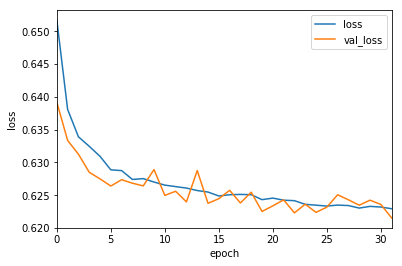

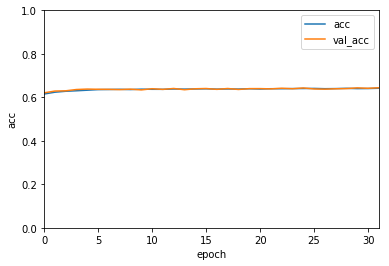

In [45]:
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
#***loss 訓練（学習）のaccuracy　学習時の誤差
#***lossのグラフでオレンジのデータ（の誤差が）上がっている場合は過学習
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

#***acc 予測時のaccuracy 誤差（学習に使っていないデータのaccuracy）
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [46]:
y_est_NN = np.argmax(model.predict(X_test_stand),axis=1)
print(y_est_NN)

[1 1 0 ... 1 0 0]


In [47]:
#正答率
d3_accuracy_NN=accuracy_score(y_test,y_est_NN)
print('正答率(Accuracy) = {:.3f}%'.format(100*d3_accuracy_NN))

#Precision,Recall,F1-score
precision_NN,recall_NN,f1_score_NN,_=precision_recall_fscore_support(y_test,y_est_NN)
print('適合率(Precision)={:.3f}%'.format(100*precision_NN[1]))
print('再現率(Recall)={:.3f}%'.format(100*recall_NN[1]))
print('F1値(F1-score)={:.3f}%'.format(100*f1_score_NN[1]))

#予測値と正解のクロス集計
conf_mat_NN=pd.DataFrame(confusion_matrix(y_test,y_est_NN),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
print(conf_mat_NN)


正答率(Accuracy) = 64.400%
適合率(Precision)=59.012%
再現率(Recall)=36.817%
F1値(F1-score)=45.345%
               予測=failed  予測=successful
正解=failed          32924           6804
正解=successful      16811           9796


特徴選択後の予測結果（SVM（手動・グリッドサーチ）、ロジスティック回帰、アダブースト（決定木））　正答率

In [48]:
print('Day1 ロジスティック回帰　正答率={:.3f}%'.format(100*d1_SGD_accuracy))
print("Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Day2 ホールドアウト法　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_h_final_SGD_accuracy))
print("Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Day2 交差検証　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Day2 交差検証　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))
print("Day3 特徴選択 交差検証　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d3_CV_final_SVM_manual_accuracy))
print("Day3 特徴選択 交差検証　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d3_CV_final_SVC_GridS_accuracy))
print("Day3 特徴選択 交差検証　ロジスティック回帰　正答率 = {:.3f}%".format(100*d3_CV_final_SGD_accuracy))
print("Day3 特徴選択 交差検証　アダブースト　正答率 = {:.3f}%".format(100*d3_CV_final_AdaB_accuracy))
print("Day3 特徴選択 ホールドアウト法　ニューラルネットワーク　正答率 = {:.3f}%".format(100*d3_accuracy_NN))


Day1 ロジスティック回帰　正答率=55.376%
Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = 61.000%
Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = 59.500%
Day2 ホールドアウト法　ロジスティック回帰　正答率 = 65.049%
Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = 58.300%
Day2 交差検証　SVM グリッドサーチ　正答率 = 58.300%
Day2 交差検証　ロジスティック回帰　正答率 = 65.424%
Day3 特徴選択 交差検証　SVM ハイパーパラメータ手動設定 正答率 = 57.240%
Day3 特徴選択 交差検証　SVM グリッドサーチ　正答率 = 57.638%
Day3 特徴選択 交差検証　ロジスティック回帰　正答率 = 62.275%
Day3 特徴選択 交差検証　アダブースト　正答率 = 54.748%
Day3 特徴選択 ホールドアウト法　ニューラルネットワーク　正答率 = 64.400%


SVMとアダブースト（決定木）は全データで学習に時間がかかるため、先頭から1000件を抽出して実施

#### Day4 主成分分析による次元削減（特徴選択前のデータ）

In [49]:
#主成分分析してみる
df_PCA=df_ks_trans.loc[:,["usd_goal_real","period"]]
#print(df_PCA.head())

#標準化
stdsc=StandardScaler()
X=stdsc.fit_transform(df_PCA)

#主成分分析
pca=PCA(n_components=2)
pca.fit(X)

print(pd.DataFrame(X).describe())

print(pca.components_)
print("寄与率=",pca.explained_variance_ratio_)
print("合計＝", pca.explained_variance_ratio_.sum())

df_PCA=pd.DataFrame({'usd_goal_real_PCA':X[:,0],'period_PCA':X[:,1]})

df_ks_PCA=pd.concat([df_ks_trans,df_PCA],axis=1)
print(df_ks_PCA.head())

df_ks_PCA=df_ks_PCA.drop(columns=['usd_goal_real','period'])


                  0             1
count  3.316750e+05  3.316750e+05
mean   4.508065e-16 -2.622543e-15
std    1.000002e+00  1.000002e+00
min   -3.743254e-02 -2.592157e+00
25%   -3.562901e-02 -3.110835e-01
50%   -3.292369e-02 -3.110835e-01
75%   -2.390597e-02  1.608628e-01
max    1.499826e+02  4.565695e+00
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
寄与率= [0.51080337 0.48919663]
合計＝ 0.9999999999999999
   usd_goal_real  state_num  Art  Comics  Crafts  Dance  Design  Fashion  \
0        1533.95        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
1       30000.00        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
2       45000.00        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
3        5000.00        0.0  0.0     0.0     0.0    0.0     0.0      0.0   
4       50000.00        1.0  0.0     0.0     0.0    0.0     0.0      0.0   

   Film & Video  Food  ...  JPY  MXN  NOK  NZD  SEK  SGD  USD  period  \
0           0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0 

C:\Users\mura\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mura\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(331675, 77)
(331675,)
(265340, 77)
(265340,)
(66335, 77)
(66335,)
Train on 265340 samples, validate on 66335 samples
Epoch 1/37
265340/265340 [==============================] - 1s 2us/sample - loss: 0.6306 - acc: 0.6457 - val_loss: 0.6243 - val_acc: 0.6512
Epoch 2/37
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6232 - acc: 0.6516 - val_loss: 0.6229 - val_acc: 0.6527
Epoch 3/37
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6204 - acc: 0.6532 - val_loss: 0.6174 - val_acc: 0.6562
Epoch 4/37
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6181 - acc: 0.6541 - val_loss: 0.6162 - val_acc: 0.6567
Epoch 5/37
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6163 - acc: 0.6551 - val_loss: 0.6145 - val_acc: 0.6598
Epoch 6/37
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6151 - acc: 0.6563 - val_loss: 0.6140 - val_acc: 0.6571
Epoch 7/37
265340/265340 [================

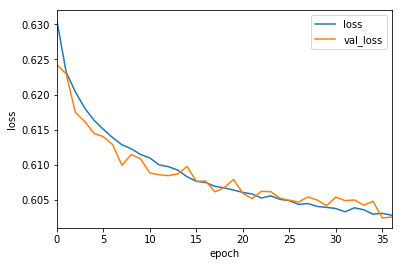

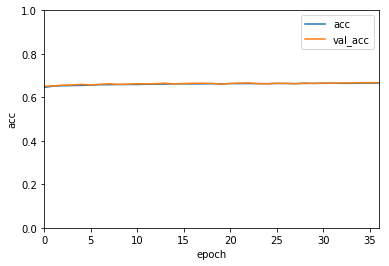

[1 0 0 ... 1 0 0]
正答率(Accuracy) = 66.716%
適合率(Precision)=62.897%
再現率(Recall)=41.497%
F1値(F1-score)=50.003%
               予測=failed  予測=successful
正解=failed          33215           6513
正解=successful      15566          11041
Day4 主成分分析　特徴選択なし  Holdout NN　正答率 = 66.716%


In [50]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense,Dropout,Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop,Adagrad,Adadelta,Adam

#説明変数と目的変数を設定
df_X=df_ks_PCA.drop(columns=['state_num'])
X, y = df_X.values, df_ks_PCA["state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

print(X_train_stand.shape)
print(y_train.shape)
print(X_test_stand.shape)
print(y_test.shape)

#モデルをつくる
model=Sequential()
model.add(Dense(48,activation='relu',input_dim=X_train_stand.shape[1]))
model.add(Dense(24,activation='relu',input_dim=48))
model.add(Dense(8,activation='relu',input_dim=24))
model.add(Dense(2,activation='softmax'))

#最適化手法
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam=Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

fit = model.fit(X_train_stand,y_train,
                epochs=37,
                batch_size=1000,
                validation_data=(X_test_stand,y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
#***loss 訓練（学習）のaccuracy　学習時の誤差
#***lossのグラフでオレンジのデータ（の誤差が）上がっている場合は過学習
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

#***acc 予測時のaccuracy 誤差（学習に使っていないデータのaccuracy）
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

y_est_NN = np.argmax(model.predict(X_test_stand),axis=1)
print(y_est_NN)

#正答率
d3_accuracy_NN=accuracy_score(y_test,y_est_NN)
print('正答率(Accuracy) = {:.3f}%'.format(100*d3_accuracy_NN))
d4_PCA_final_NN_accuracy = d3_accuracy_NN

#Precision,Recall,F1-score
precision_NN,recall_NN,f1_score_NN,_=precision_recall_fscore_support(y_test,y_est_NN)
print('適合率(Precision)={:.3f}%'.format(100*precision_NN[1]))
print('再現率(Recall)={:.3f}%'.format(100*recall_NN[1]))
print('F1値(F1-score)={:.3f}%'.format(100*f1_score_NN[1]))

#予測値と正解のクロス集計
conf_mat_NN=pd.DataFrame(confusion_matrix(y_test,y_est_NN),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
print(conf_mat_NN)

print("Day4 主成分分析　特徴選択なし  Holdout NN　正答率 = {:.3f}%".format(100*d4_PCA_final_NN_accuracy))


In [51]:
#説明変数と目的変数を設定
df_X=df_ks_PCA.drop(columns=['state_num'])
X, y = df_X.values, df_ks_PCA["state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
PCA_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)


    #学習
    clf_SGD=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                     fit_intercept=True,random_state=1234,tol=1e-3)
    clf_SGD.fit(X_train_stand,y_train)

    #予測
    y_est_SGD=clf_SGD.predict(X_test_stand)

    #正答率
    accuracy_SGD=accuracy_score(y_test,y_est_SGD)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_SGD))

    #Precision,Recall,F1-score
    precision_SGD,recall_SGD,f1_score_SGD,_=precision_recall_fscore_support(y_test,y_est_SGD)
    print('適合率(Precision)={:.3f}%'.format(100*precision_SGD[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_SGD[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_SGD[1]))

    #予測値と正解のクロス集計
    conf_mat_SGD=pd.DataFrame(confusion_matrix(y_test,y_est_SGD),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_SGD)
    
   
    PCA_SGD_accuracy += accuracy_SGD

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d4_PCA_final_SGD_accuracy = PCA_SGD_accuracy / n_split

print("Day4 主成分分析　KV法　ロジスティック回帰　正答率 = {:.3f}%".format(100*d4_PCA_final_SGD_accuracy))


(331675, 77)
(331675,)
(265340, 77)
(265340,)
(66335, 77)
(66335,)
正答率(Accuracy) = 65.927%
適合率(Precision)=61.051%
再現率(Recall)=41.579%
F1値(F1-score)=49.468%
               予測=failed  予測=successful
正解=failed          32670           7058
正解=successful      15544          11063
(265340, 77)
(265340,)
(66335, 77)
(66335,)
正答率(Accuracy) = 65.132%
適合率(Precision)=58.733%
再現率(Recall)=46.871%
F1値(F1-score)=52.136%
               予測=failed  予測=successful
正解=failed          30608           8851
正解=successful      14279          12597
(265340, 77)
(265340,)
(66335, 77)
(66335,)
正答率(Accuracy) = 65.612%
適合率(Precision)=58.444%
再現率(Recall)=52.451%
F1値(F1-score)=55.286%
               予測=failed  予測=successful
正解=failed          29422          10027
正解=successful      12784          14102
(265340, 77)
(265340,)
(66335, 77)
(66335,)
正答率(Accuracy) = 65.130%
適合率(Precision)=58.152%
再現率(Recall)=48.761%
F1値(F1-score)=53.044%
               予測=failed  予測=successful
正解=failed          30139           9402
正解=su

#### Day4 主成分分析（特徴選択後）

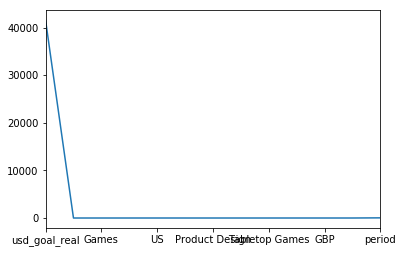

In [52]:
#説明変数と目的変数を設定
df_X=df_ks_select.drop('state_num',axis=1).loc[:,:]
X, y = df_X.values, df_ks_select.loc[:,"state_num"].values

#各説明変数の平均値の確認
display(df_X.mean().plot())


In [53]:
#標準化
stdsc=StandardScaler()
X=stdsc.fit_transform(df_X)

#主成分分析の実行
pca=PCA(copy=False,n_components=X.shape[1])
X_new=pca.fit_transform(X)

#寄与率
print("寄与率=",pca.explained_variance_ratio_)
print("合計=",pca.explained_variance_ratio_.sum())

C:\Users\mura\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mura\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


寄与率= [2.47465631e-01 1.48880906e-01 1.28614475e-01 9.41849497e-02
 8.21066681e-02 7.72273586e-02 7.36798196e-02 6.02003377e-02
 4.80379304e-02 2.85086389e-02 1.09570842e-02 1.04696901e-04
 3.15025840e-05]
合計= 1.0000000000000004


(331675, 13)
(331675,)
(265340, 13)
(265340,)
(66335, 13)
(66335,)
Train on 265340 samples, validate on 66335 samples
Epoch 1/42
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6537 - acc: 0.6144 - val_loss: 0.6434 - val_acc: 0.6220
Epoch 2/42
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6417 - acc: 0.6234 - val_loss: 0.6450 - val_acc: 0.6086
Epoch 3/42
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6377 - acc: 0.6266 - val_loss: 0.6322 - val_acc: 0.6321
Epoch 4/42
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6351 - acc: 0.6302 - val_loss: 0.6347 - val_acc: 0.6361
Epoch 5/42
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6336 - acc: 0.6321 - val_loss: 0.6311 - val_acc: 0.6358
Epoch 6/42
265340/265340 [==============================] - 0s 1us/sample - loss: 0.6322 - acc: 0.6335 - val_loss: 0.6317 - val_acc: 0.6338
Epoch 7/42
265340/265340 [================

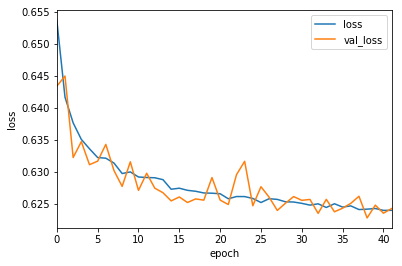

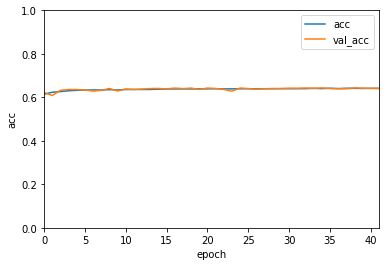

[1 1 0 ... 1 0 0]
正答率(Accuracy) = 64.200%
適合率(Precision)=57.288%
再現率(Recall)=42.233%
F1値(F1-score)=48.622%
               予測=failed  予測=successful
正解=failed          31350           8378
正解=successful      15370          11237
Day4 主成分分析　特徴選択  Holdout NN　正答率 = 64.200%


In [54]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense,Dropout,Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop,Adagrad,Adadelta,Adam

print(X_new.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

print(X_train_stand.shape)
print(y_train.shape)
print(X_test_stand.shape)
print(y_test.shape)

#モデルをつくる
model=Sequential()
model.add(Dense(24,activation='relu',input_dim=X_train_stand.shape[1]))
model.add(Dense(8,activation='relu',input_dim=24))
model.add(Dense(2,activation='softmax'))

#最適化手法
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam=Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

fit = model.fit(X_train_stand,y_train,
                epochs=42,
                batch_size=1000,
                validation_data=(X_test_stand,y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
#***loss 訓練（学習）のaccuracy　学習時の誤差
#***lossのグラフでオレンジのデータ（の誤差が）上がっている場合は過学習
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

#***acc 予測時のaccuracy 誤差（学習に使っていないデータのaccuracy）
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

y_est_NN = np.argmax(model.predict(X_test_stand),axis=1)
print(y_est_NN)

#正答率
d3_accuracy_NN=accuracy_score(y_test,y_est_NN)
print('正答率(Accuracy) = {:.3f}%'.format(100*d3_accuracy_NN))
d4_PCA_lasso_NN_accuracy = d3_accuracy_NN

#Precision,Recall,F1-score
precision_NN,recall_NN,f1_score_NN,_=precision_recall_fscore_support(y_test,y_est_NN)
print('適合率(Precision)={:.3f}%'.format(100*precision_NN[1]))
print('再現率(Recall)={:.3f}%'.format(100*recall_NN[1]))
print('F1値(F1-score)={:.3f}%'.format(100*f1_score_NN[1]))

#予測値と正解のクロス集計
conf_mat_NN=pd.DataFrame(confusion_matrix(y_test,y_est_NN),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
print(conf_mat_NN)

print("Day4 主成分分析　特徴選択  Holdout NN　正答率 = {:.3f}%".format(100*d4_PCA_lasso_NN_accuracy))


In [55]:
#説明変数と目的変数を設定
print(X_new.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
PCA_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X_new, y):

    X_train, y_train = X_new[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X_new[test_idx],y[test_idx] #テスト用データ
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)


    #学習
    clf_SGD=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                     fit_intercept=True,random_state=1234,tol=1e-3)
    clf_SGD.fit(X_train_stand,y_train)

    #予測
    y_est_SGD=clf_SGD.predict(X_test_stand)

    #正答率
    accuracy_SGD=accuracy_score(y_test,y_est_SGD)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_SGD))

    #Precision,Recall,F1-score
    precision_SGD,recall_SGD,f1_score_SGD,_=precision_recall_fscore_support(y_test,y_est_SGD)
    print('適合率(Precision)={:.3f}%'.format(100*precision_SGD[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_SGD[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_SGD[1]))

    #予測値と正解のクロス集計
    conf_mat_SGD=pd.DataFrame(confusion_matrix(y_test,y_est_SGD),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_SGD)
    
   
    PCA_SGD_accuracy += accuracy_SGD

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d4_PCA_lasso_SGD_accuracy = PCA_SGD_accuracy / n_split



(331675, 13)
(331675,)
(265340, 13)
(265340,)
(66335, 13)
(66335,)
正答率(Accuracy) = 62.511%
適合率(Precision)=57.930%
再現率(Recall)=23.873%
F1値(F1-score)=33.812%
               予測=failed  予測=successful
正解=failed          35115           4613
正解=successful      20255           6352
(265340, 13)
(265340,)
(66335, 13)
(66335,)
正答率(Accuracy) = 62.288%
適合率(Precision)=57.806%
再現率(Recall)=25.625%
F1値(F1-score)=35.509%
               予測=failed  予測=successful
正解=failed          34432           5027
正解=successful      19989           6887
(265340, 13)
(265340,)
(66335, 13)
(66335,)
正答率(Accuracy) = 61.952%
適合率(Precision)=59.248%
再現率(Recall)=19.624%
F1値(F1-score)=29.482%
               予測=failed  予測=successful
正解=failed          35820           3629
正解=successful      21610           5276
(265340, 13)
(265340,)
(66335, 13)
(66335,)
正答率(Accuracy) = 62.424%
適合率(Precision)=56.208%
再現率(Recall)=31.559%
F1値(F1-score)=40.423%
               予測=failed  予測=successful
正解=failed          32953           6588
正解=su

In [56]:
print('Day1 ロジスティック回帰　正答率                                 = {:.3f}%'.format(100*d1_SGD_accuracy))
print("Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率    = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Day2 ホールドアウト法　SVM グリッドサーチ　正答率               = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Day2 ホールドアウト法　ロジスティック回帰　正答率               = {:.3f}%".format(100*d2_h_final_SGD_accuracy))
print("Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率            = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Day2 交差検証　SVM グリッドサーチ　正答率                       = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Day2 交差検証　ロジスティック回帰　正答率                       = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))
print("Day3 特徴選択 交差検証　SVM ハイパーパラメータ手動設定 正答率   = {:.3f}%".format(100*d3_CV_final_SVM_manual_accuracy))
print("Day3 特徴選択 交差検証　SVM グリッドサーチ　正答率              = {:.3f}%".format(100*d3_CV_final_SVC_GridS_accuracy))
print("Day3 特徴選択 交差検証　ロジスティック回帰　正答率              = {:.3f}%".format(100*d3_CV_final_SGD_accuracy))
print("Day3 特徴選択 交差検証　アダブースト　正答率                    = {:.3f}%".format(100*d3_CV_final_AdaB_accuracy))
print("Day3 特徴選択 ホールドアウト法　ニューラルネットワーク　正答率  = {:.3f}%".format(100*d3_accuracy_NN))
print("Day4 主成分分析　特徴選択なし  Holdout NN　正答率               = {:.3f}%".format(100*d4_PCA_final_NN_accuracy))
print("Day4 主成分分析　特徴選択なし　KV法　ロジスティック回帰　正答率 = {:.3f}%".format(100*d4_PCA_final_SGD_accuracy))
print("Day4 主成分分析　特徴選択  Holdout NN　正答率                   = {:.3f}%".format(100*d4_PCA_lasso_NN_accuracy))
print("Day4 主成分分析　特徴選択　KV法　ロジスティック回帰　正答率     = {:.3f}%".format(100*d4_PCA_lasso_SGD_accuracy))


Day1 ロジスティック回帰　正答率                                 = 55.376%
Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率    = 61.000%
Day2 ホールドアウト法　SVM グリッドサーチ　正答率               = 59.500%
Day2 ホールドアウト法　ロジスティック回帰　正答率               = 65.049%
Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率            = 58.300%
Day2 交差検証　SVM グリッドサーチ　正答率                       = 58.300%
Day2 交差検証　ロジスティック回帰　正答率                       = 65.424%
Day3 特徴選択 交差検証　SVM ハイパーパラメータ手動設定 正答率   = 57.240%
Day3 特徴選択 交差検証　SVM グリッドサーチ　正答率              = 57.638%
Day3 特徴選択 交差検証　ロジスティック回帰　正答率              = 62.275%
Day3 特徴選択 交差検証　アダブースト　正答率                    = 54.748%
Day3 特徴選択 ホールドアウト法　ニューラルネットワーク　正答率  = 64.200%
Day4 主成分分析　特徴選択なし  Holdout NN　正答率               = 66.716%
Day4 主成分分析　特徴選択なし　KV法　ロジスティック回帰　正答率 = 65.488%
Day4 主成分分析　特徴選択  Holdout NN　正答率                   = 64.200%
Day4 主成分分析　特徴選択　KV法　ロジスティック回帰　正答率     = 62.304%


Day4 主成分分析　特徴選択なし  Holdout NN　正答率               = 66.716%